In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

df = pd.read_csv('openpowerlifting.csv', low_memory=False)

2.4.1


# Process Data

- take name, age, body weight, and 3 squat columns, then rename columns
- drop NaN values
- create new dataframe with top squat
- remove rows where all squats are negative (squat failed)

In [2]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.4,56,NaN,...,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


In [3]:
df['Sex'] = df['Sex'].astype('str')
df = df[['Sex', 'Age', 'BodyweightKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg']]
df.columns = ['sex', 'age', 'body_weight', 'squat1', 'squat2', 'squat3']

In [4]:
df.head()

,sex,age,body_weight,squat1,squat2,squat3
0,F,29.0,59.8,80.0,92.5,105.0
1,F,29.0,58.5,100.0,110.0,120.0
2,F,40.0,55.4,NaN,NaN,NaN
3,F,23.0,60.0,-105.0,-105.0,105.0
4,F,45.0,104.0,120.0,130.0,140.0


In [5]:
df = df.dropna()

In [6]:
rows = []
for index, row in df.iterrows():
    max_squat = max([row['squat1'], row['squat2'], row['squat3']])
    rows.append([row['sex'], row['age'], row['body_weight'], max_squat])
    
df = pd.DataFrame(rows, columns = ['sex', 'age', 'body_weight', 'max_squat'])
del rows

In [7]:
index = df[df['max_squat'] < 0 ].index
df = df.drop(index)

Use only one gender for now

In [8]:
index = df[df['sex'] == "M"].index
df = df.drop(index)

del df['sex']

In [9]:
df['max_squat'].mean()

120.35207287368902

In [10]:
df.dtypes

age            float64
body_weight    float64
max_squat      float64
dtype: object

In [11]:
df.head()

,age,body_weight,max_squat
0,29.0,59.8,105.0
1,29.0,58.5,120.0
2,23.0,60.0,105.0
3,45.0,104.0,140.0
4,37.0,74.0,142.5


In [12]:
def plot(x, y, ax, title, y_label):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.plot(x, y)
    ax.margins(x=0, y=0)

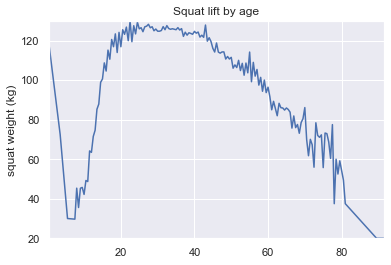

In [13]:
group_by_age = df.loc[:, ['age', 'body_weight', 'max_squat']].groupby('age')
age_avgs = group_by_age.mean()
x = age_avgs.index
y1 = age_avgs.max_squat

fig, ax = plt.subplots()
plot(x, y1, ax, 'Squat lift by age', 'squat weight (kg)')

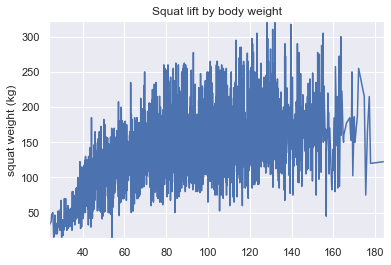

In [14]:
group_by_body_weight = df.loc[:, ['age', 'body_weight', 'max_squat']].groupby('body_weight')
body_weight_avgs = group_by_body_weight.mean()
x = body_weight_avgs.index
y1 = body_weight_avgs.max_squat

fig, ax = plt.subplots()
plot(x, y1, ax, 'Squat lift by body weight', 'squat weight (kg)')

In [15]:
# split into training and testing
train_dataset = df.sample(frac=0.8, random_state = 0)
test_dataset = df.drop(train_dataset.index)

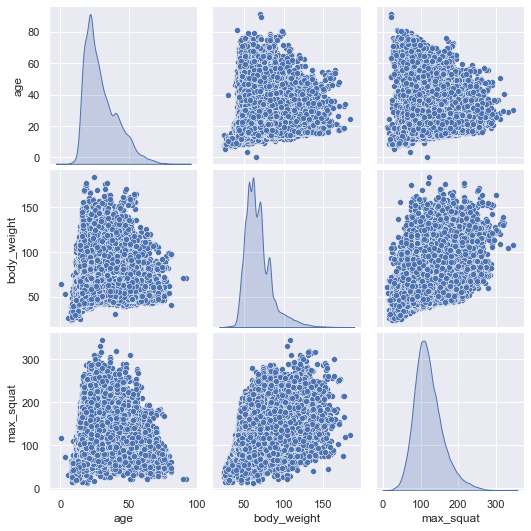

In [16]:
sns.pairplot(train_dataset[['age', 'body_weight', 'max_squat']], diag_kind='kde')

In [17]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,64374.0,29.555799,11.776010,0.5,20.5,26.5,36.5,91.5
body_weight,64374.0,67.669684,16.729378,24.0,56.0,64.2,74.7,184.2
max_squat,64374.0,120.411316,37.871769,11.3,95.0,115.0,140.0,345.0


In [18]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('max_squat')
test_labels = test_features.pop('max_squat')

In [19]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
age,29.555799,11.776010
body_weight,67.669684,16.729378
max_squat,120.411316,37.871769


In [20]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[29.5558   67.669685]
First example: [[27.   63.59]]

Normalized: [[-0.22 -0.24]]


## One variable linear regression

In [21]:
body_weight = np.array(train_features['body_weight'])

body_weight_normalizer = preprocessing.Normalization(input_shape=[1,])
body_weight_normalizer.adapt(body_weight)

In [22]:
body_weight_model = tf.keras.Sequential([
    body_weight_normalizer,
    layers.Dense(units=1)
])

body_weight_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [23]:
body_weight_model.predict(body_weight[:30])

array([[ 0.38765207],
       [ 0.5482359 ],
       [-0.6680208 ],
       [-1.4091778 ],
       [-0.29744306],
       [ 0.13584903],
       [-0.9891892 ],
       [-0.08839843],
       [-1.3616678 ],
       [ 0.86655337],
       [-1.1811295 ],
       [ 1.5934569 ],
       [-0.20242298],
       [ 1.0328386 ],
       [ 1.1288086 ],
       [-0.7155309 ],
       [-0.1644148 ],
       [ 0.88840795],
       [ 1.5915568 ],
       [ 1.0565935 ],
       [ 1.1373605 ],
       [ 0.14915179],
       [-1.3711696 ],
       [ 0.56723994],
       [-1.4756916 ],
       [ 0.0541317 ],
       [ 0.66226006],
       [-0.506487  ],
       [ 0.80954105],
       [-0.15016164]], dtype=float32)

In [24]:
body_weight_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [25]:
%%time
history = body_weight_model.fit(
    train_features['body_weight'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)



CPU times: user 2min 19s, sys: 24.4 s, total: 2min 43s
Wall time: 1min 51s


In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,27.216270,27.360498,95
96,27.208368,27.367643,96
97,27.210703,27.371088,97
98,27.215748,27.364323,98
99,27.211670,27.354805,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([20, 40])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

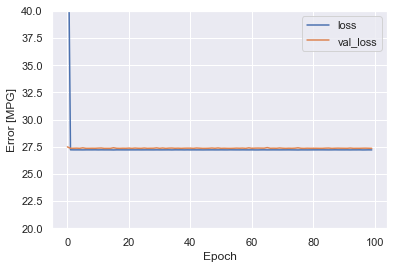

In [28]:
plot_loss(history)

In [29]:
test_results = {}

test_results['body_weight_model'] = body_weight_model.evaluate(
    test_features['body_weight'],
    test_labels, verbose=0)

In [30]:
x = tf.linspace(0.0, 250, 251)
y = body_weight_model.predict(x)

In [31]:
def plot_body_weight(x, y):
  plt.scatter(train_features['body_weight'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('body weight')
  plt.ylabel('max squat')
  plt.legend()

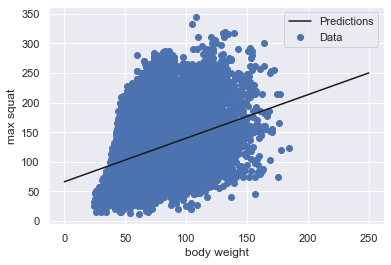

In [32]:
plot_body_weight(x, y)

## Multivariable linear regression

In [33]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])


array([[ 0.27494833],
       [-4.088293  ],
       [-1.7232693 ],
       [ 1.6428096 ],
       [ 0.24364865],
       [ 1.0198935 ],
       [-2.2207108 ],
       [ 1.5940559 ],
       [-1.4147226 ],
       [-0.3086142 ]], dtype=float32)

In [34]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[-1.332763 ],
       [ 0.0586772]], dtype=float32)>

In [35]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [36]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 44s, sys: 15.4 s, total: 1min 59s
Wall time: 1min 15s


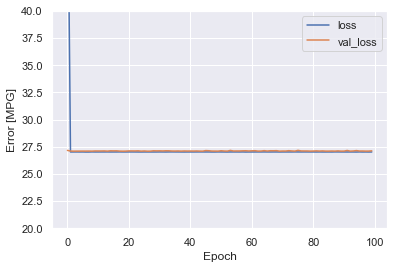

In [37]:
plot_loss(history)

In [38]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Single Input DNN

In [39]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [40]:
dnn_body_weight_model = build_and_compile_model(body_weight_normalizer)

In [41]:
dnn_body_weight_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [42]:
%%time
history = dnn_body_weight_model.fit(
    train_features['body_weight'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3min 59s, sys: 1min 7s, total: 5min 7s
Wall time: 2min 10s


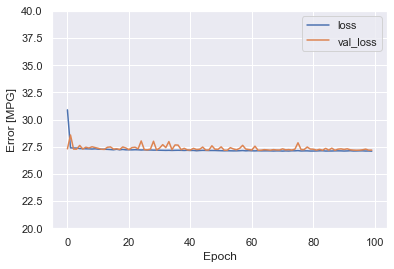

In [43]:
plot_loss(history)

In [44]:
x = tf.linspace(0.0, 250, 251)
y = dnn_body_weight_model.predict(x)

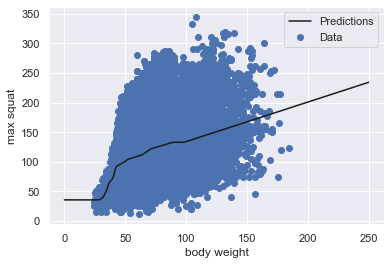

In [45]:
plot_body_weight(x, y)

In [46]:
test_results['dnn_body_weight_model'] = dnn_body_weight_model.evaluate(
    test_features['body_weight'], test_labels,
    verbose=0)

## Multi-Input DNN

In [47]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [48]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4min 3s, sys: 1min 8s, total: 5min 12s
Wall time: 2min 11s


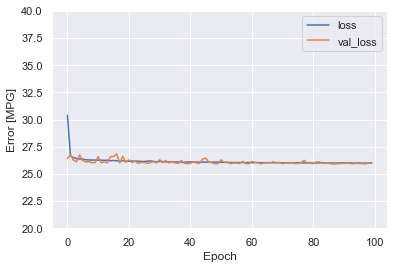

In [49]:
plot_loss(history)

In [50]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [51]:
pd.DataFrame(test_results, index=['Mean asbolute error [squat_weight]']).T

,Mean asbolute error [squat_weight]
body_weight_model,27.389374
linear_model,27.229523
dnn_body_weight_model,27.227571
dnn_model,26.261042


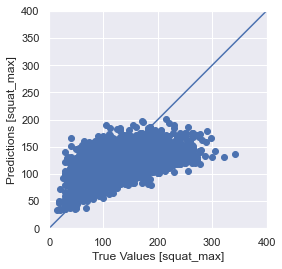

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [squat_max]')
plt.ylabel('Predictions [squat_max]')
lims = [0, 400]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

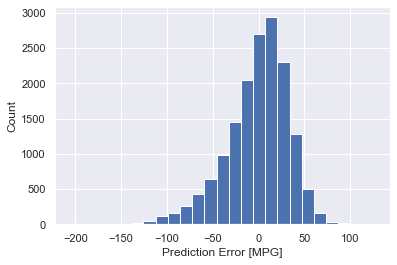

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

## Results Summary

There is not very much correlation in this dataset. As a result, the model may not be effective for our app. In addition, this dataset comes from powerlifting *competitions*, which may not translate well for beginners, which is our targeted demographic.